In [1]:
 !nvidia-smi

Thu May 27 07:44:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd "/content/gdrive/My Drive/Colab Notebooks"

/content/gdrive/My Drive/Colab Notebooks


DataLoader

In [4]:
from os import listdir
from os.path import join

from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize, Grayscale

import random
import math
from torch.autograd import Variable
import torch

import torchvision.transforms as transforms

# gray = transforms.Gray()
import numpy as np

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', 'bmp', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, blocksize):
    return crop_size - (crop_size % blocksize)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        RandomHorizontalFlip(p=0.5),
        RandomVerticalFlip(p=0.5),
        Grayscale(),
        ToTensor(),
    ])



def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    if mse < 1.0e-10:
        return 100
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX/math.sqrt(mse))

def to_var(x, requires_grad=False, volatile=False):
    """
    Varialbe type that automatically choose cpu or cuda
    """
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad, volatile=volatile)

class TrainDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, crop_size, blocksize):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        crop_size = calculate_valid_crop_size(crop_size, blocksize)
        self.hr_transform = train_hr_transform(crop_size)

    def __getitem__(self, index):
        try:
            hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
            return hr_image, hr_image
        except:
            hr_image = self.hr_transform(Image.open(self.image_filenames[index+1]))
            return hr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)


class TestDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, blocksize, crop_size=96):
        super(TestDatasetFromFolder, self).__init__()
        self.blocksize = blocksize
        self.high_res_length = crop_size
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        self.test_compose = Compose([
            CenterCrop(crop_size),
            Grayscale(),
            ToTensor(),
            # transforms.Normalize(mean=0.5, std=0.5)
        ])

    def __getitem__(self, index):
        hr_image = Image.open(self.image_filenames[index])

        hr_image = self.test_compose(hr_image)
            
        return hr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)



二值化

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

# ********************* 二值(+-1) ***********************
# A
class Binary_a(Function):

    @staticmethod
    def forward(self, input):
        self.save_for_backward(input)
        output = torch.sign(input)
        return output

    @staticmethod
    def backward(self, grad_output):
        input, = self.saved_tensors
        #*******************ste*********************
        grad_input = grad_output.clone()
        #****************saturate_ste***************
        grad_input[input.ge(1)] = 0
        grad_input[input.le(-1)] = 0
        '''
        #******************soft_ste*****************
        size = input.size()
        zeros = torch.zeros(size).cuda()
        grad = torch.max(zeros, 1 - torch.abs(input))
        #print(grad)
        grad_input = grad_output * grad
        '''
        return grad_input
# W
class Binary_w(Function):

    @staticmethod
    def forward(self, input):
        output = torch.sign(input)
        return output

    @staticmethod
    def backward(self, grad_output):
        #*******************ste*********************
        grad_input = grad_output.clone()
        return grad_input
# ********************* 三值(+-1、0) ***********************
class Ternary(Function):

    @staticmethod
    def forward(self, input):
        # **************** channel级 - E(|W|) ****************
        E = torch.mean(torch.abs(input), (3, 2, 1), keepdim=True)
        # **************** 阈值 ****************
        threshold = E * 0.7
        # ************** W —— +-1、0 **************
        output = torch.sign(torch.add(torch.sign(torch.add(input, threshold)),torch.sign(torch.add(input, -threshold))))
        return output, threshold

    @staticmethod
    def backward(self, grad_output, grad_threshold):
        #*******************ste*********************
        grad_input = grad_output.clone()
        return grad_input

# ********************* A(特征)量化(二值) ***********************
class activation_bin(nn.Module):
  def __init__(self, A):
    super().__init__()
    self.A = A
    self.relu = nn.ReLU(inplace=True)

  def binary(self, input):
    output = Binary_a.apply(input)
    return output

  def forward(self, input):
    if self.A == 2:
      output = self.binary(input)
      # ******************** A —— 1、0 *********************
      #a = torch.clamp(a, min=0)
    else:
      output = self.relu(input)
    return output
# ********************* W(模型参数)量化(三/二值) ***********************
def meancenter_clampConvParams(w):
    mean = w.data.mean(1, keepdim=True)
    w.data.sub(mean) # W中心化(C方向)
    w.data.clamp(-1.0, 1.0) # W截断
    return w

class weight_tnn_bin(nn.Module):
  def __init__(self, W):
    super().__init__()
    self.W = W
    self.mask_flag = False

  def binary(self, input):
    output = Binary_w.apply(input)
    return output

  def ternary(self, input):
    output = Ternary.apply(input)
    return output

  def cal_mask_ternary(self, weights, rate=70): #暂时未使用
    mask = []
    origin_weights = list(weights.cpu().data.abs().numpy().flatten()) #
    if len(origin_weights) != len(origin_weights):
        print("维度不匹配不予剪枝")
        return torch.ones(weights.size())
    threshold_weight = np.percentile(np.array(origin_weights), rate)
    data_len = len(origin_weights)
    count = 0
    for i in range(data_len):
        prun_val = 1
        if origin_weights[i] < threshold_weight and self.atten_mask[i] == 1:
            prun_val = 0
            count += 1
        mask.append(prun_val)
    # print("true cut rate:", count / data_len)
    mask = torch.tensor(mask)
    mask = to_var(mask)#Variable(mask, requires_grad=False, volatile=False)
    mask = mask.view(weights.size())
    return mask

  def set_atten_mask(self, mask):
    self.atten_mask = mask
    # self.mask = self.cal_mask_ternary(output, 50)
    # self.weight.data = self.weight.data * self.mask.data
    self.mask_flag = True

  def set_mask(self, mask):
      self.mask = mask
      self.mask_flag = True


  def forward(self, input):
    if self.W == 2 or self.W == 3:
        # **************************************** W二值 *****************************************
        if self.W == 2:
            output = meancenter_clampConvParams(input) # W中心化+截断
            # output = input
            # **************** channel级 - E(|W|) ****************
            E = torch.mean(torch.abs(output), (3, 2, 1), keepdim=True)
            # **************** α(缩放因子) ****************
            alpha = E
            # ************** W —— +-1 **************
            if hasattr(self, "mask_flag") and self.mask_flag:
                # self.mask = self.cal_mask_ternary(output, 50)
                # print("output device:",output.device,"mask device:",self.mask.device)
                output = output * self.mask            
            output = self.binary(output)  #加个if判断有没有flag
            # ************** W * α **************
            output = output * alpha # 若不需要α(缩放因子)，注释掉即可
            # **************************************** W三值 *****************************************
        elif self.W == 3:
            output_fp = input.clone()
            # ************** W —— +-1、0 **************
            output, threshold = self.ternary(input)
            # **************** α(缩放因子) ****************
            output_abs = torch.abs(output_fp)
            mask_le = output_abs.le(threshold)
            mask_gt = output_abs.gt(threshold)
            output_abs[mask_le] = 0
            output_abs_th = output_abs.clone()
            output_abs_th_sum = torch.sum(output_abs_th, (3, 2, 1), keepdim=True)
            mask_gt_sum = torch.sum(mask_gt, (3, 2, 1), keepdim=True).float()
            alpha = output_abs_th_sum / mask_gt_sum # α(缩放因子)
            # *************** W * α ****************
            # output = output * alpha # 若不需要α(缩放因子)，注释掉即可
    else:
      output = input
    return output

# ********************* 量化卷积（同时量化A/W，并做卷积） ***********************
class Conv2d_Q(nn.Conv2d):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        bias=False,
        A=2,
        W=2
      ):
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias
        )
        # 实例化调用A和W量化器
        # self.activation_quantizer = activation_bin(A=A)
        self.weight_quantizer = weight_tnn_bin(W=W)
        self.mask_flag = False
          
    def forward(self, input):
        # 量化A和W
        # bin_input = self.activation_quantizer(input)
        tnn_bin_weight = self.weight_quantizer(self.weight)    
        #print(bin_input)
        if self.mask_flag:
            tnn_bin_weight = tnn_bin_weight * self.mask

        # print(tnn_bin_weight[0][0][0][:])
        # 用量化后的A和W做卷积
        output = F.conv2d(
            input=input, 
            weight=tnn_bin_weight, 
            bias=self.bias, 
            stride=self.stride, 
            padding=self.padding, 
            dilation=self.dilation, 
            groups=self.groups)
        return output

    def set_mask(self, mask):
        # self.mask = mask
        self.weight_quantizer.set_mask(mask)#set_atten_mask(mask)
        # self.weight.data = self.weight.data * self.mask.data
        # self.mask_flag = True

    def get_mask(self):
        print(self.weight_quantizer.mask_flag)
        return self.weight_quantizer.atten_mask

Attention Layer

In [6]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c,)
        return y

class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_dim, activation, blocksize=32):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = activation
        self.blocksize = blocksize

        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels = in_dim//8 , kernel_size= 1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels = in_dim//8 , kernel_size= 1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels = in_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
        # #bug聚集地
        # self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # self.linear = nn.Linear(in_features=in_dim, out_features=in_dim*blocksize*blocksize,bias=True)
        # #end 
        self.softmax  = nn.Softmax(dim=-1) #
    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N)
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)

        out = self.gamma*out + x
        '''bug聚集地'''
        # atten = self.avg_pool(out).view(m_batchsize,C)
        # atten = self.linear(atten)
        # atten = atten.view(m_batchsize, C, self.blocksize, self.blocksize)
        return out  # B * C * blocksize * blocksize

In [7]:
class csPart(nn.Module):
    def __init__(self, blocksize=32, subrate=0.2, channel=1):
        super(csPart, self).__init__()
        #sampling
        self.sampling = Conv2d_Q(
            in_channels=channel, 
            out_channels=int(np.round(blocksize*blocksize*subrate*channel)), 
            kernel_size=blocksize, 
            stride=blocksize, 
            padding=0, 
            bias=False, 
            W=2)
        # self.sampling = nn.Conv2d(in_channels=channel, 
        #     out_channels=int(np.round(blocksize*blocksize*subrate*channel)), 
        #     kernel_size=blocksize, 
        #     stride=blocksize, 
        #     padding=0, 
        #     bias=False)
        
        # self.bn = nn.BatchNorm2d(int(np.round(blocksize*blocksize*subrate*channel)))

        self.gamma = nn.Parameter(torch.zeros(1))
        # self.gamma.data[0] = -0.5
        # self.atten = SELayer(channel=int(np.round(blocksize*blocksize*subrate*channel), reduction=16))
        self.atten = Self_Attn(in_dim=int(np.round(blocksize*blocksize*subrate*channel)), activation=False, blocksize=blocksize) #SELayer(channel=int(np.round(blocksize*blocksize*subrate*channel)), reduction=16)
        # self.sampling = nn.Conv2d(1, int(np.round(blocksize*blocksize*subrate)), blocksize, stride=blocksize, padding=0, bias=False)
        #init reconstruction
        self.upsampling = nn.Conv2d(int(np.round(blocksize*blocksize*subrate*channel)), blocksize*blocksize, 1, stride=1, padding=0)
        # self.upsampling = nn.Sequential(
        #     nn.Conv2d(int(np.round(blocksize*blocksize*subrate*channel)), blocksize*blocksize, 1, stride=1, padding=0, bias=True),
        #     nn.LeakyReLU()
        # )
        
        self.dwc = nn.Sequential(
            nn.Conv2d(in_channels=blocksize * blocksize,
                      out_channels=blocksize * blocksize,
                      kernel_size=1, stride=1, padding=0,
                      groups=blocksize * blocksize),
            # nn.LeakyReLU(),
            nn.Conv2d(in_channels=blocksize * blocksize, out_channels=blocksize*blocksize, kernel_size=1, padding=0),
            # nn.LeakyReLU()
        )
        # self.activation = nn.LeakyReLU()

    def forward(self, input):
        x = self.sampling(input)
        # x = self.bn(x)
        x = self.gamma * x + x
        atten_matrix = self.atten(x)
        x = self.upsampling(atten_matrix)
        # x = self.activation(x)
        x = self.dwc(x)# + x
        # x = self.activation(x)
        return x

class sconv2d(nn.Module):
    def __init__(self, channels=64, outchannels=64):
        super(sconv2d, self).__init__()
        self.channels = channels
        self.separable_conv2d = nn.Sequential(
            nn.Conv2d(in_channels=channels,
                      out_channels=channels,
                      kernel_size=(1, 1), stride=1, padding=0,
                      groups=channels),
            nn.Conv2d(in_channels=channels, out_channels=outchannels, kernel_size=(1, 1), padding=0),
            # nn.LeakyReLU()
        )
        # self.relu = nn.LeakyReLU()
    
    def forward(self, input):
        x = self.separable_conv2d(input)
        # x = self.relu(x)
        return x


class baseblock(nn.Module):
    def __init__(self, channels=64):
        super(baseblock, self).__init__()
        
        self.conv1 = nn.Sequential(
            # nn.Conv2d(channels, channels, kernel_size=(3, 3), stride=1, padding=1, bias=True),
            sconv2d(channels=channels),
            nn.LeakyReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            # nn.Conv2d(channels, channels, kernel_size=(3, 3), stride=1, padding=1, bias=True),
            sconv2d(channels=channels),
            nn.LeakyReLU(inplace=True)
        )
        # self.relu = nn.LeakyReLU()
    def forward(self, input):
        # x = self.relu(input)
        x = self.conv1(input)
        x = x + input
        x = self.conv2(x)
        return x


class DenseBlock(nn.Module):
    def __init__(self, conv_in, conv_out, k_size, beta=0.2):
        super(DenseBlock, self).__init__()

        self.res1 = nn.Sequential(
            # nn.Conv2d(conv_in, conv_out, kernel_size=(k_size, k_size), stride=1, padding=1),
            sconv2d(channels=conv_in, outchannels=conv_out),
            nn.LeakyReLU(inplace=True)
        )

        self.res2 = nn.Sequential(
            # nn.Conv2d(conv_in*2, conv_out, kernel_size=(k_size, k_size), stride=1, padding=1),
            sconv2d(channels=conv_in*2, outchannels=conv_out),
            nn.LeakyReLU(inplace=True)
        )

        self.res3 = nn.Sequential(
            # nn.Conv2d(conv_in*3, conv_out, kernel_size=(k_size, k_size), stride=1, padding=1),
            sconv2d(channels=conv_in*3, outchannels=conv_out),
            # nn.LeakyReLU(inplace=True)
        )

        # self.res4 = nn.Sequential(
            # nn.Conv2d(conv_in*4, conv_out, kernel_size=(k_size, k_size), stride=1, padding=1),
            # sconv2d(channels=conv_in*4, outchannels=conv_out),
            # nn.LeakyReLU(inplace=True),
        # )

        # self.res5 = nn.Sequential(
        #     nn.Conv2d(conv_in*5, conv_out, kernel_size=(k_size, k_size), stride=1, padding=1),
        #     sconv2d(channels=conv_in*3, outchannels=conv_out),
        # )
        self.beta = beta

    def forward(self, input):
        x = input
        #feature size = convin*2
        result = self.res1(x)
        x = torch.cat([x, result], 1)

        result = self.res2(x)
        # print(x.shape,result.shape)
        x = torch.cat([x, result], 1)
        

        x = self.res3(x)
        # x = torch.cat([x, result], 1)

        # x = self.res4(x)
        # x = torch.cat([x, result], 1)

        # x = self.res5(x)

        output = x.mul(self.beta)
        return output + input

class ResidualInResidualDenseBlock(nn.Module):
    def __init__(self, conv_in=64, k_size=3, beta=0.2):
        super(ResidualInResidualDenseBlock, self).__init__()

        self.dense1 = DenseBlock(conv_in, conv_in, k_size)
        self.dense2 = DenseBlock(conv_in, conv_in, k_size)
        self.dense3 = DenseBlock(conv_in, conv_in, k_size)
        self.beta = beta

    def forward(self, input):
        x = self.dense1(input)
        x = self.dense2(x)
        x = self.dense3(x)
        output = x.mul(self.beta)
        return output + input



In [8]:
class CSNetPlus(nn.Module):
    def __init__(self,blocksize=32, subrate=0.2, channels=1):
        super(CSNetPlus, self).__init__()
        self.blocksize = blocksize
        self.subrate = subrate
        self.channels = channels
        n_baseblock = 10
        outchannels = 64

        self.csPart = csPart(blocksize, subrate, channels)
        self.rrdb = ResidualInResidualDenseBlock(conv_in=outchannels, k_size=3,)
        self.reshape = nn.PixelShuffle(upscale_factor=self.blocksize)
        self.dalconv = nn.Sequential(
                    nn.Conv2d(in_channels=outchannels,
                        out_channels=outchannels,
                        kernel_size=(3, 3),
                        stride=1,
                        padding=2,
                        dilation=2,
                        bias=True),
                    nn.LeakyReLU(inplace=True))

        self.dr1 = nn.Sequential(
            nn.Conv2d(channels, outchannels, kernel_size=(3, 3), stride=1, padding=1, bias=True),
            nn.LeakyReLU(inplace=True)
        )
        baseblock_layers = []
        for i in range(n_baseblock):
            if( i%2 == 1):
                baseblock_layers.append(nn.Sequential(
                    nn.Conv2d(in_channels=outchannels,
                        out_channels=outchannels,
                        kernel_size=(3, 3),
                        stride=1,
                        padding=2,
                        dilation=2,
                        bias=True),
                    nn.LeakyReLU(inplace=True)))
                
            # baseblock_layers.append(ResidualInResidualDenseBlock(conv_in=outchannels, k_size=3,))
            baseblock_layers.append(DenseBlock(conv_in=outchannels, conv_out=outchannels, k_size=3, beta=0.3))
            
        self.baseblock_seq = nn.Sequential(*baseblock_layers)

        self.out_conv = nn.Conv2d(outchannels, 1, kernel_size=(3, 3), stride=1, padding=1, bias=True)
        

    def forward(self, input):
        x = self.csPart(input)
        # x = self.rrdb(x)
        reshape = self.reshape(x)
        
        dr1 = self.dr1(reshape)
        # x = self.rrdb(dr1)
        # x = self.rrdb(x)
        x = self.baseblock_seq(dr1)
        x = self.out_conv(x)
        x = x + reshape
        return x, reshape



In [9]:
!pip install pytorch-msssim
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

剪枝使用的代码

In [10]:
"""参数化，区别是否需要反向传播更新"""
def to_var(x, requires_grad=False, volatile=False):
    """
    Varialbe type that automatically choose cpu or cuda
    """
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad, volatile=volatile)

"""中心化"""
def meancenter_clampConvParams(w):
    mean = w.data.mean(1, keepdim=True)
    w.data.sub(mean) # W中心化(C方向)
    w.data.clamp(-1.0, 1.0) # W截断
    return w

#计算峰值信噪比
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)


def atten_cal_mask(atten_matrix, origin_matrix, pruning_perc=50):
    print("=========>calculate atten mask")
    atten_mask = []
    campare_matrix = atten_matrix.cpu() - origin_matrix.cpu()
    atten_cal_weights = list(campare_matrix.cpu().data.numpy().flatten())
    threshold_atten = np.percentile(np.array(atten_cal_weights), pruning_perc)
    data_len = len(atten_cal_weights)
    # count = 0
    for i in range(data_len):
        prun_val = 1
        if atten_cal_weights[i] < threshold_atten:
            prun_val = 0
            # count += 1
        atten_mask.append(prun_val)
    # print("true cut rate:", count / data_len)
    print("=========>atten mask calculate finish")
    return atten_mask


#计算掩码以用于 对权重矩阵进行做哈达玛积，进而实现三值化
#要不要abs？ Yes And No
#atten_cal_mask(atten_matrix=torch.load("path")["atten_matrix"], origin_matrix=model.csPart.sampling.weight, pruning_perc=30)
def atten_cal_mask_old(atten_matrix, origin_matrix, pruning_perc):
    print("=========>calculate mask")
    masks = []
    origin_matrix = meancenter_clampConvParams(origin_matrix)
    campare_matrix = atten_matrix.cpu() - origin_matrix.cpu()
    atten_cal_weights = list(campare_matrix.cpu().data.numpy().flatten())
    origin_weights = list(origin_matrix.cpu().data.abs().numpy().flatten())
    threshold_weight = np.percentile(np.array(origin_weights), 50)
    threshold_atten = np.percentile(np.array(atten_cal_weights), pruning_perc)
    data_len = len(atten_cal_weights)
    count = 0
    for i in range(data_len):
        prun_val = 1
        if origin_weights[i] < threshold_weight and atten_cal_weights[i] < threshold_atten:
            prun_val = 0
            count += 1
        masks.append(prun_val)
    print("true cut rate:", count / data_len)
    masks = torch.tensor(masks)
    masks = to_var(masks)
    masks = masks.view(origin_matrix.size())
    print("=========>mask calculate finish")
    return masks

#为三值化载入权重Attention矩阵时使用
class targetPart(nn.Module):
    def __init__(self, blocksize=32, subrate=0.3, channel=1):
        super(targetPart, self).__init__()
        self.gamma = nn.Parameter(torch.zeros(1))#torch.Tensor([-0.3960])
        self.real_atten = nn.Conv2d(in_channels=channel, out_channels=int(np.round(blocksize*blocksize*subrate*channel)), kernel_size=blocksize, stride=blocksize, padding=0, bias=False)
    def forward(self, input):
        x = self.real_atten(input)
        x = (self.gamma + 1) * x
        return x

Train

In [ ]:
import argparse, os, heapq
import torch
import torchvision
import math, random
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from torchvision import models
import torch.utils.model_zoo as model_zoo
import matplotlib.pyplot as plt
from PIL import Image


# Training settings
parser = argparse.ArgumentParser(description="PyTorch SRResNet")
parser.add_argument("--batchSize", type=int, default=32, help="training batch size")
parser.add_argument("--nEpochs", type=int, default=1000, help="number of epochs to train for")
parser.add_argument("--lr", type=float, default=1e-4, help="Learning Rate. Default=1e-4")
parser.add_argument("--step", type=int, default=200, help="Sets the learning rate to the initial LR decayed by momentum every n epochs, Default: n=500")
parser.add_argument("--cuda", action="store_true", help="Use cuda?")
parser.add_argument("--resume", default="", type=str, help="Path to checkpoint (default: none)")
parser.add_argument("--start-epoch", default=1, type=int, help="Manual epoch number (useful on restarts)")
parser.add_argument("--threads", type=int, default=4, help="Number of threads for data loader to use, Default: 1")
parser.add_argument("--pretrained", default="", type=str, help="path to pretrained model (default: none)")
parser.add_argument("--vgg_loss", action="store_true", help="Use content loss?")
parser.add_argument("--gpus", default="0", type=str, help="gpu ids (default: 0)")

def main():

    global opt, model, netContent
    input_args = []
    opt = parser.parse_args([])
    # print(opt)
    channel = 1
    opt.vgg_loss = True if channel==3 else False
    opt.cuda = True
    # opt.pretrained = "CSNetPlus_model_t/0.2_denseBlock3*10.pth"#0.2_888.6.pth" 
    # opt.pretrained = "/content/checkpoint/model_epoch_969_.pth"#  #
    opt.pretrained = "saved_models/0.5/f_ten_db3_10_33.03.pth"#db3_10_30.2.pth"
    opt.lr = 0.0003
    scheduler_step_size=80
    scheduler_gamma=0.5
    regularization_lambda = 1e-4
    blocksize = 32
    subrate = 0.5
    cuda = opt.cuda
    attention_path = "CSNetPlus_model_mask/0.5_0.0067.pth"#0.1_0.00598.pth"#0.25_0.00548.pth"
    if cuda:
        print("=> use gpu id: '{}'".format(opt.gpus))
        os.environ["CUDA_VISIBLE_DEVICES"] = opt.gpus
        if not torch.cuda.is_available():
                raise Exception("No GPU found or Wrong gpu id, please run without --cuda")

    opt.seed = random.randint(1, 10000)
    print("Random Seed: ", opt.seed) #5868  3878
    torch.manual_seed(opt.seed)
    if cuda:
        torch.cuda.manual_seed(opt.seed)

    cudnn.benchmark = True

    print("===> Loading datasets")
    # train_set = DatasetFromHdf5("/path/to/your/hdf5/data/like/rgb_srresnet_x4.h5")
    train_data_val2017 = 'dataSet/val2017'
    train_data_train2017 = "dataSet/2017/train2017"
    train_data_BSDS500 = 'dataSet/BSDS500/data/images/train'
    test_data = 'dataSet/Test/Set12/'

    train_path = train_data_val2017
    train_set = TrainDatasetFromFolder(train_path, crop_size=96, blocksize=32)
    test_set = TestDatasetFromFolder(test_data, blocksize=32)
    # train_loader = DataLoader(dataset=train_set, num_workers=4, batch_size=opt.batchSize, shuffle=True)

    training_data_loader = DataLoader(dataset=train_set, num_workers=opt.threads, \
        batch_size=opt.batchSize, shuffle=True)
    testing_data_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=0)

    if opt.vgg_loss:
        print('===> Loading VGG model')
        netVGG = models.vgg19()
        netVGG.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/vgg19-dcbb9e9d.pth'))
        class _content_model(nn.Module):
            def __init__(self):
                super(_content_model, self).__init__()
                self.feature = nn.Sequential(*list(netVGG.features.children())[:-1])
                
            def forward(self, x):
                out = self.feature(x)
                return out

        netContent = _content_model()

    print("===> Building model")
    model = CSNetPlus(blocksize=32, subrate=subrate, channels=channel)
    
    criterion = nn.MSELoss(size_average=False)
    # criterion = SSIM(win_size=11, win_sigma=1.5, data_range=1, size_average=True, channel=1)

    print("===> Setting GPU")
    if cuda:
        model = model.cuda()
        criterion = criterion.cuda()
        if opt.vgg_loss:
            netContent = netContent.cuda() 

    # optionally resume from a checkpoint
    if opt.resume:
        if os.path.isfile(opt.resume):
            print("=> loading checkpoint '{}'".format(opt.resume))
            checkpoint = torch.load(opt.resume)
            opt.start_epoch = checkpoint["epoch"] + 1
            model.load_state_dict(checkpoint["model"].state_dict())
        else:
            print("=> no checkpoint found at '{}'".format(opt.resume))

    # optionally copy weights from a checkpoint
    if opt.pretrained:
        if os.path.isfile(opt.pretrained):
            print("=> loading model '{}'".format(opt.pretrained))
            weights = torch.load(opt.pretrained)
            model.load_state_dict(weights['model'].state_dict())
        else:
            print("=> no model found at '{}'".format(opt.pretrained))

    print("===> Setting Optimizer")
    optimizer = optim.Adam(model.parameters(), lr=opt.lr, betas=(0.9, 0.999))
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

    print("===> Training")
    now_min_loss = float('inf')
    max_val_psnr = 20
    global max_psnr_epoch,real_max_val_psnr,heap
    max_psnr_epoch = 0
    real_max_val_psnr = 0
    heap = []
    #计算mask用于三值化
    atten_mask = atten_cal_mask_old(atten_matrix=torch.load(attention_path)["atten_matrix"], origin_matrix=model.csPart.sampling.weight, pruning_perc=70)
    # atten_mask = torch.load("saved_models/0.4/f_ten_db3_10_32.63.pth")["mask"]
    model.csPart.sampling.set_mask(atten_mask)
    
    for epoch in range(opt.start_epoch, opt.nEpochs + 1):
        # epoch_loss = train(training_data_loader, optimizer, scheduler, model, criterion, epoch, testing_data_loader)
        val_psnr = train(training_data_loader, optimizer, scheduler, model, criterion, epoch, testing_data_loader)
        save_checkpoint("/content/checkpoint/", model, epoch, atten_mask, 0)
        if val_psnr > real_max_val_psnr:
            real_max_val_psnr = val_psnr
            max_psnr_epoch = epoch
        if epoch <= 5 :
            heapq.heappush(heap,(val_psnr,epoch))
        elif val_psnr > heapq.nsmallest(1,heap)[0][0]:
            heapq.heapreplace(heap,(val_psnr,epoch))

        # if epoch%5 == 0 and epoch_loss < 1000 and epoch_loss < now_min_loss:
        if epoch%5 == 0 and val_psnr > 27.5 and val_psnr > max_val_psnr:
            save_checkpoint("/content/gdrive/My Drive/Colab Notebooks/CSNetPlus_model_t/",model,epoch,atten_mask,val_psnr) #epoch_loss
            # now_min_loss = epoch_loss
            max_val_psnr = val_psnr

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10"""
    lr = opt.lr * (0.1 ** (epoch // opt.step))
    return lr 

def train(training_data_loader, optimizer, scheduler, model, criterion, epoch, testing_data_loader):
    
    train_bar = tqdm(training_data_loader)
    running_results = {'batch_sizes': 0, 'loss': 0, }
    # lr = adjust_learning_rate(optimizer, epoch-1)
    # for param_group in optimizer.param_groups:
    #     param_group["lr"] = lr
    model.train()
    scheduler.step()
    # wgt1 = 1 if epoch < 200 else 2
    # wgt2 = 3 - wgt1
    # for iteration, batch in enumerate(training_data_loader, 1):
    for data, target in train_bar:
        batch_size = data.size(0)
        if batch_size <= 0:
            continue

        running_results['batch_sizes'] += batch_size
        real_img = Variable(target)
        if opt.cuda:
            real_img = real_img.cuda()

        z = Variable(data)
        if opt.cuda:
            z = z.cuda()
        fake_img, reshape = model(z)
        #对atten层添加 L0.5 正则化   atten 要单独计算从(模型中return回来---待完成)
        # lhalf_loss = torch.norm(atten, p=0.5)
        loss = criterion(fake_img, real_img) #+ criterion(reshape, real_img) #regularization_lambda*lhalf_loss
        # loss = (1 - loss) * 100

        if opt.vgg_loss:
            content_input = netContent(fake_img)
            content_target = netContent(real_img)
            content_target = content_target.detach()
            content_loss = criterion(content_input, content_target)

        optimizer.zero_grad()

        if opt.vgg_loss:
            netContent.zero_grad()
            content_loss.backward(retain_graph=True)

        loss.backward()

        optimizer.step()
        running_results['loss'] += loss.item() * batch_size

        train_bar.set_description(desc='[%d] Loss: %.4f lr: %.7f' % (
            epoch, running_results['loss'] / running_results['batch_sizes'], optimizer.param_groups[0]['lr']))
        
    #val
    val_psnr = 0
    model.eval()
    low_res_sample, high_res_sample = next(iter(testing_data_loader))
    fake_images,_ = model(low_res_sample.cuda())
    fake_images = fake_images.cpu().detach()
    # print(low_res_sample.size(0))
    for idx in range(low_res_sample.size(0)):
        fake_image = fake_images.data[idx].numpy().astype(np.float32)
        fake_image = fake_image*255.
        fake_image[fake_image<0] = 0
        fake_image[fake_image>255.] = 255.
        fake_image = fake_image[0,:,:]

        im_res_y = high_res_sample.data[idx].numpy().astype(np.float32)

        im_res_y = im_res_y*255.
        im_res_y[im_res_y<0] = 0
        im_res_y[im_res_y>255.] = 255. 
        im_res_y = im_res_y[0,:,:]
        psnr = PSNR(im_res_y, fake_image, shave_border=0)
        # print(psnr)
        val_psnr += psnr
    val_psnr /= low_res_sample.size(0)
    print("val_psnr: ", val_psnr)

    # show samples
    # low_res_sample, high_res_sample = next(iter(testing_data_loader))
    # idx = np.random.randint(0, 14, 1)
    # fake_image,_ = model(low_res_sample[idx].cuda())
    # fake_image = fake_image.cpu().detach()
    # ground_truth = high_res_sample[idx]
    # image_grid = torchvision.utils.make_grid([fake_image[0], ground_truth[0]], nrow=2, normalize=True)
    # _, plot = plt.subplots(figsize=(12, 12))
    # plt.axis('off')
    # plot.imshow(image_grid.permute(1, 2, 0))
    # plt.savefig("CSNetPlus_CheckpointImage" + '/epoch_{}_checkpoint.jpg'.format(epoch), bbox_inches='tight')
    # return running_results['loss'] / running_results['batch_sizes']
    return val_psnr


def save_checkpoint(path, model, epoch, mask=None, epoch_loss=0):
    model_out_path = path + "model_epoch_{}_{}.pth".format(epoch, "" if epoch_loss==0 else epoch_loss)
    state = {"epoch": epoch ,"model": model, "mask": mask}
    if not os.path.exists(path):
        os.makedirs(path)

    torch.save(state, model_out_path)

    print("Checkpoint saved to {}".format(model_out_path))

if __name__ == "__main__":
    main()

In [ ]:
print("epoch:",max_psnr_epoch,"  psnr:",real_max_val_psnr) #
print(heap)

=> use gpu id: '0'
Processing  dataSet/Test/Set11_mat/flinstones.mat
(512, 512)


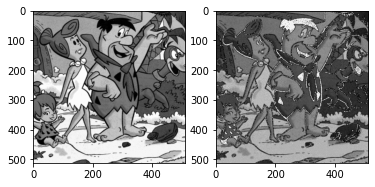

27.44846381598931 0.8457900285720825
Processing  dataSet/Test/Set11_mat/lena256.mat
(256, 256)


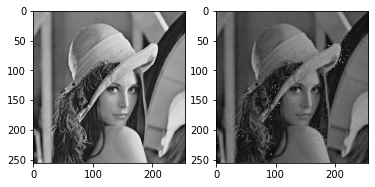

31.13423348998999 0.9011733531951904
Processing  dataSet/Test/Set11_mat/peppers256.mat
(256, 256)


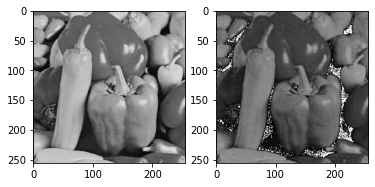

31.059781958820082 0.8976731896400452
Processing  dataSet/Test/Set11_mat/Monarch.mat
(256, 256)


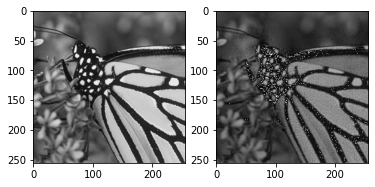

30.127423568975914 0.9204978942871094
Processing  dataSet/Test/Set11_mat/cameraman.mat
(256, 256)


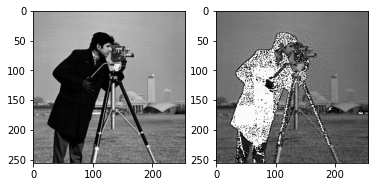

27.963695589741295 0.863204300403595
Processing  dataSet/Test/Set11_mat/fingerprint.mat
(512, 512)


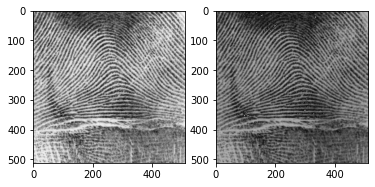

28.62678936377355 0.9324997067451477
Processing  dataSet/Test/Set11_mat/house.mat
(256, 256)


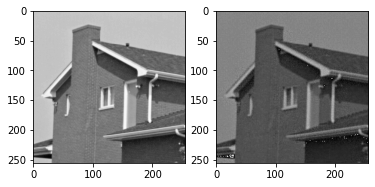

34.38990992387784 0.888290524482727
Processing  dataSet/Test/Set11_mat/foreman.mat
(256, 256)


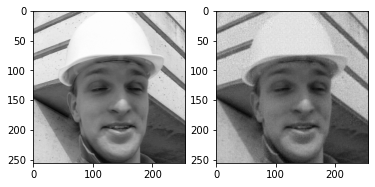

36.46755945652262 0.9387208223342896
Processing  dataSet/Test/Set11_mat/Parrots.mat
(256, 256)


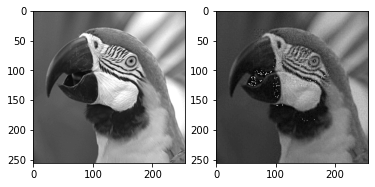

30.61038339162986 0.9128299951553345
Processing  dataSet/Test/Set11_mat/boats.mat
(256, 256)


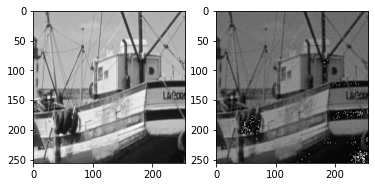

31.829735130168796 0.9004833102226257
Processing  dataSet/Test/Set11_mat/barbara.mat
(256, 256)


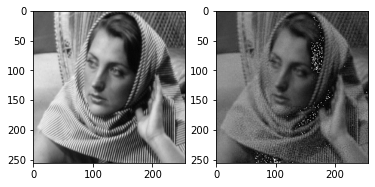

26.616628133971922 0.8117145895957947
Dataset= Set11
PSNR_predicted= 30.57041852940556 0.8920797922394492
It takes 0.10608410835266113s for processing


In [13]:
import argparse, os
import matplotlib.pyplot as plt
import numpy as np
import time, math, glob
import scipy.io as sio
import cv2
from PIL import Image


def showimg(img, fake_img, subrate=0.1):
    #fake_img = getimg("resImages/babytmpc22hn1_5.png")
    # plt.axis("off")
    # subrate = 0.2
    img = img.convert('L')
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.subplot(1, 2, 2)
    # plt.axis('off')
    plt.imshow(fake_img,cmap='gray')
    # plt.savefig("result_images" + '/butterfly_{}.jpg'.format(subrate), bbox_inches='tight')
    # print("image saved as butterfly_{}.jpg".format(subrate))
    plt.show()


parser = argparse.ArgumentParser(description="PyTorch SRResNet Eval")
parser.add_argument("--cuda", action="store_true", help="use cuda?")
parser.add_argument("--model", default="model/model_srresnet.pth", type=str, help="model path")
parser.add_argument("--dataset", default="Set11", type=str, help="dataset name, Default: Set5")
parser.add_argument("--gpus", default="0", type=str, help="gpu ids (default: 0)")

# def PSNR(pred, gt, shave_border=0):
#     height, width = pred.shape[:2]
#     pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
#     gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
#     imdff = pred - gt
#     rmse = math.sqrt(np.mean(imdff ** 2))
#     if rmse == 0:
#         return 100
#     return 20 * math.log10(255.0 / rmse)

opt = parser.parse_args([])

opt.cuda = True
# opt.model =  "/content/checkpoint/model_epoch_800_.pth" #"CSNetPlus_model_t/model_epoch_435_17.98640433730782.pth" #
# opt.model = "CSNetPlus_model_t/0.2_denseBlock3*10.pth"#0.2_888.6.pth"#-1+1_noPurning_depthwise_0.2.pth"  #loss:600
opt.model = "saved_models/0.25/f_ten_db3_10_%3_30.57.pth"
attention_path = "CSNetPlus_model_mask/bin_0.25_0.00627.pth"

subrate = 0.5

cuda = opt.cuda

if cuda:
    print("=> use gpu id: '{}'".format(opt.gpus))
    os.environ["CUDA_VISIBLE_DEVICES"] = opt.gpus
    if not torch.cuda.is_available():
            raise Exception("No GPU found or Wrong gpu id, please run without --cuda")

model = torch.load(opt.model,)["model"] #map_location=torch.device('cpu')
# atten_mask = atten_cal_mask_old(atten_matrix=torch.load(attention_path)["atten_matrix"], origin_matrix=model.csPart.sampling.weight, pruning_perc=50)
# # atten_mask = None#torch.load("/content/checkpoint/model_epoch_1_.pth")["mask"]
# model.csPart.sampling.set_mask(atten_mask)
model.eval()
image_list = glob.glob("dataSet/Test/" + opt.dataset + "_mat/*.*") 

avg_psnr_predicted = 0.0
avg_elapsed_time = 0.0
avg_ssim_val = 0.0

pos = 0
for image_name in image_list:
    # pos += 1
    # if pos != 1:
    #     continue
    print("Processing ", image_name)
    im_gt_y = sio.loadmat(image_name)['im_gt_y']

    im_gt_y = im_gt_y.astype(float)
    print(im_gt_y.shape)
    X = Variable(torch.from_numpy(im_gt_y).float()).view(1, -1, im_gt_y.shape[0], im_gt_y.shape[1])
    im_input = im_gt_y/255.
    
    im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
    # print(im_input)
    if cuda:
        model = model.cuda()
        im_input = im_input.cuda()
    else:
        model = model.cpu()

    start_time = time.time()
    res, reshape = model(im_input)
    elapsed_time = time.time() - start_time
    avg_elapsed_time += elapsed_time

    from torchvision import transforms

    unloader = transforms.ToPILImage()
    # image = res.cpu().clone()  # clone the tensor
    image = reshape.cpu().clone()
    image = image.squeeze(0)  # remove the fake batch dimension
    image = unloader(image)
    showimg(Image.fromarray(im_gt_y), image, subrate)

    res = res.cpu()
    im_res_y = res.data[0].numpy().astype(np.float32)

    im_res_y = im_res_y*255.
    im_res_y[im_res_y<0] = 0
    im_res_y[im_res_y>255.] = 255. 
    im_res_y = im_res_y[0,:,:]
    Y = res*255.
    Y[Y<0] = 0
    Y[Y>255.] = 255

    psnr_predicted = PSNR(im_gt_y, im_res_y,shave_border=0)
    ssim_val = ssim( X, Y, data_range=255, size_average=True) # return (N,)
    # ms_ssim_val = ms_ssim( X, Y, data_range=255, size_average=False ) #(N,)
    # print(ssim_val.item())
    
    print( + psnr_predicted, + ssim_val.item())
    avg_psnr_predicted += psnr_predicted
    avg_ssim_val += ssim_val.item()



print("Dataset=", opt.dataset)
print("PSNR_predicted=", avg_psnr_predicted/len(image_list), avg_ssim_val/len(image_list))
print("It takes {}s for processing".format(avg_elapsed_time))

In [ ]:
hasattr(model.csPart.sampling.weight_quantizer, "mask_flag")

True

In [ ]:

parm={}
for name,parameters in model.named_parameters():
    print(name,':',parameters.size())
    parm[name]=parameters.detach().cpu().numpy()

In [ ]:
model.csPart.gamma
model.csPart.sampling.get_mask()

True


AttributeError: ignored

In [ ]:
!cp "/content/checkpoint/model_epoch_969_.pth" "./saved_models/0.5/f_ten_db3_10_33.03.pth"

标准PyTorch载入测试图像

In [13]:
import math
import time
from os import listdir
from os.path import join
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_msssim import ssim
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, \
    ToTensor, Resize, Grayscale

# from modules import *


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', 'bmp', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def showimg(img, fake_img, subrate=0.1):
    # fake_img = getimg("resImages/babytmpc22hn1_5.png")
    # plt.axis("off")
    # subrate = 0.2
    img = img.convert('L')
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.subplot(1, 2, 2)
    # plt.axis('off')
    plt.imshow(fake_img, cmap='gray')
    # plt.savefig("result_images" + '/butterfly_{}.jpg'.format(subrate), bbox_inches='tight')
    # print("image saved as butterfly_{}.jpg".format(subrate))
    plt.show()


class test_dataset_for_folder(Dataset):
    def __init__(self, dataset_dir, crop_size=256):
        super(test_dataset_for_folder, self).__init__()
        # self.blocksize = blocksize
        self.high_res_length = crop_size
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        self.test_compose = Compose([
            # CenterCrop(crop_size),
            Grayscale(),
            ToTensor(),
            # Resize(crop_size),
            # transforms.Normalize(mean=0.5, std=0.5)
        ])

    def __getitem__(self, index):
        hr_image = Image.open(self.image_filenames[index])

        hr_image = self.test_compose(hr_image)

        return hr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)


def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

def up2ssim255(y):
    y = y * 255.
    y[y < 0] = 0
    y[y > 255.] = 255
    return y

def image_in_model_test(data_path, model_path, crop_size=256, cuda=False, ):
    image_filenames = [join(data_path, x) for x in listdir(data_path) if is_image_file(x)]
    test_compose = Compose([
        # CenterCrop(crop_size),
        Grayscale(),
        # Resize((crop_size, crop_size)),
        ToTensor(),
        # transforms.Normalize(mean=0.5, std=0.5)
    ])

    model = torch.load(model_path, map_location=torch.device('cpu'))["model"]  #
    if cuda:
        model = model.cuda()

    else:
        model = model.cpu()
    model.eval()
    #  print(low_res_sample.size(0))
    total_elapsed_time = 0
    avg_psnr_predicted = 0
    avg_ssim_val = 0
    for image_name in image_filenames:
        origin_image = Image.open(image_name)
        origin_image_tensor = test_compose(origin_image)
        x = origin_image_tensor.view(1, -1, origin_image_tensor.shape[1], origin_image_tensor.shape[2])
        if cuda:
            x = x.cuda()

        start_time = time.time()
        fake_image, _ = model(x)
        elapsed_time = time.time() - start_time
        total_elapsed_time += elapsed_time

        from torchvision import transforms

        unloader = transforms.ToPILImage()
        output_image = fake_image.cpu().clone()  # clone the tensor
        output_image = output_image.squeeze(0)  # remove the fake batch dimension
        output_image = unloader(output_image)
        origin_image_gray = unloader(origin_image_tensor)
        # a,b = np.array(input_image),np.array(output_image)
        showimg(origin_image_gray, output_image, 1)
        X = x.cpu()
        X = up2ssim255(X)
        Y = fake_image.cpu()
        Y = up2ssim255(Y)

        psnr_predicted = PSNR(np.array(origin_image_gray), np.array(output_image), shave_border=0)
        ssim_val = ssim(X, Y, data_range=255, size_average=True)  # return (N,)
        # ms_ssim_val = ms_ssim( X, Y, data_range=255, size_average=False ) #(N,)
        # print(ssim_val.item())

        print(+ psnr_predicted, + ssim_val.item())
        avg_psnr_predicted += psnr_predicted
        avg_ssim_val += ssim_val.item()

    print("Dataset=", data_path)
    print("PSNR_predicted=", avg_psnr_predicted / len(image_filenames), avg_ssim_val / len(image_filenames))
    print("It takes {}s for processing".format(total_elapsed_time / len(image_filenames)))


image_in_model_test('/content/gdrive/MyDrive/Colab Notebooks/dataSet/datasets/Set14',
                    "/content/gdrive/MyDrive/Colab Notebooks/saved_models/0.01/db3_10_20.89.pth", 
                    cuda=True)

RuntimeError: ignored